In [1]:

#from Tools import *
from photoObject import *
import numpy as np
import seaborn as sns
import pandas as pd
from BayesianInference import *
from random import Random
import random
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous
from astropy.io import ascii
import emcee
import pathos.multiprocessing as multiproc
from multiprocessing import Pool
import corner
from IPython.display import display, Math


In [2]:

Catalog=ascii.read('../../A-Catalogs/Binospec-Candels.cat')
Photometry = [PhotoObject(c) for c in Catalog]


### Lets make mock Muv and Redshifts

- First assume Muv is Gaussianly distributed

In [3]:

def Muv_mock(mean,std_dev):
    values = np.random.normal(mean, std_dev, 1000)
    mask= (values<-18.5) & (values>-23)
    return values[mask]

Muv=Muv_mock(-20,1)
BInf=BayesInf()
BInf.Muv=Muv

In [4]:
%load_ext autoreload
%autoreload

mockParamsA=[0.1,0.8]
mockParamsW=[8,120]

ew,prob,A,W=BInf.GenerateMockData(mockParamsA,mockParamsW)
intrinsicEW=[RandomSampler(a,w) for a,w in zip(A,W)]
BInf.EW=intrinsicEW
Noise=5
EW_obs=BInf.RandomDrawEW(noise=Noise)
BInf.EW_obs=np.array(EW_obs)
BInf.noise=Noise
BInf.dEW=np.array([Noise for i in range(len(intrinsicEW))])
dEW=BInf.dEW
Detection_type=BInf.Classify(SNcut=3)
wtab=BInf.GenerateWtab()

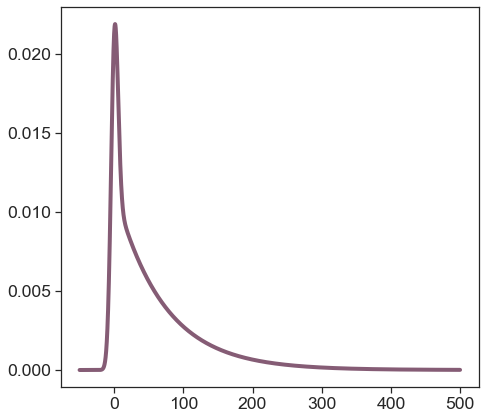

In [5]:
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
def Likelihood_TEST(ew,dEW,A,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    dEW_2 = dEW**2.
    p1 = (1. - A) * np.exp(-0.5 * ew**2./dEW_2) / np.sqrt(2.*np.pi) / dEW
    X  = (dEW_2/Wo - ew) / np.sqrt(2.) / dEW
    p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

ew=np.round( np.linspace(-50, 500, num=5501), decimals=1)
dew=np.full(len(ew),Noise)

cmap = ListedColormap(Antique_3.mpl_colors)
sns.set_theme(style="ticks",font_scale=1.6)
plt.rcParams["figure.figsize"] = (7.5,7.)
fig, axs = plt.subplots()

y=Likelihood_TEST(ew,dew,0.8,70)
axs.plot(ew,y,lw=4,color=cmap(0.1),label=r"M$_\mathrm{UV}$ = -18.9, $\mathrm{\beta}$ = -2")

In [6]:
def Likelihood(ew,dEW,A,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    if Wo<0:
        A=0

    dEW_2 = dEW**2.
    p1 = (1. - A) * np.exp(-0.5 * ew**2./dEW_2) / np.sqrt(2.*np.pi) / dEW
    X  = (dEW_2/Wo - ew) / np.sqrt(2.) / dEW
    p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

def ParameterModel(physParams,mathParams):
    """
    ParameterModel: Given the physical parameters and the mathematical parameters, it returns the parameter of the model
    
    Input:
    - physParams: Physical parameters (Muv)
    - mathParams: Mathematical parameters (Constants of the model A and Wo)
    Output:
    - Parameter: Parameter of the model A or Wo
    """
    Muv=physParams
    cMuv,cte= mathParams[0],mathParams[1]
    Parameter   =   ((Muv+20)*cMuv)  +   cte 
    return Parameter


def LikNoDet(wtab,dew,A,Wo):
        like = Likelihood(wtab,dew,A,Wo)
        return integrate.trapz(like,wtab)


def Posterior(ew,dew,physParams,mathParamsA,mathParamsW):
    """
    

    """
    A=ParameterModel(physParams,mathParamsA)
    Wo=ParameterModel(physParams,mathParamsW)
    #probLike=self.Likelihood(ew,A,Wo)
    probLike=[]
    for i in range(0,len(Detection_type)):
        if Detection_type[i]=="LAE":
            p   =   Likelihood(ew[i],dew[i],A[i],Wo[i])
        if Detection_type[i]=="nonLAE":
            p   =   LikNoDet(wtab,dew[i],A[i],Wo[i])
        if np.isnan(p)==True:
            continue

        probLike.append(p)
        
    return np.array(probLike)

def log_prior(theta,physParams=Muv):
    # I can put priors here or in the equation in the BInf object 
    Auv,Ac,Wuv,Wc= theta
    A =   ParameterModel(physParams,[Auv,Ac])
    W =   ParameterModel(physParams,[Wuv,Wc])
    #print(A,W)
    if (A >= 0.).all() and (A <=1.0).all() and (W > 0.).all():# and (W < 500.).all():
        return 0.0 

    return -np.inf

def log_likelihood(theta,y,yerr,physParams=Muv):
    Auv,Ac,Wuv,Wc = theta
    model = Posterior(y,yerr,physParams,[Auv,Ac],[Wuv,Wc]) # Does thus have to be exp, so it gets outside the logaritm?

    return np.sum(np.log(model))


def log_probability(theta, y, yerr):
    DrawnphysParams=Muv
    
    lp = log_prior(theta,physParams=DrawnphysParams)
    if not np.isfinite(lp):
        return -np.inf
    
    lL=log_likelihood(theta, y, yerr,physParams=DrawnphysParams)
    #print(lL)
    if np.isnan(lL)==True:
        return -np.inf
    else:
        return lp + lL

In [7]:
steps=1000
nwalkers=10

#mockParamsA=[0.12,3.2]
#mockParamsW=[8,230]

inValuesA=[0,0]
inValuesW=[0,0]

inValues=inValuesA+inValuesW


pos = inValues+ [0.01,0.2,1,30] * np.random.randn(nwalkers,len(inValues) )
nwalkers, ndim = np.shape(pos)

#mp_pool = multiproc.ProcessPool(nodes=8)
#with mp_pool as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(EW_obs , dEW,)
)
sampler.run_mcmc(pos, steps, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 94%|█████████▍| 944/1000 [05:27<00:19,  2.86it/s]<ipython-input-6-5e47c9f2d449>:16: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-6-5e47c9f2d449>:16: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100%|██████████| 1000/1000 [05:45<00:00,  2.89it/s]


State([[7.54080729e-02 8.20061565e-01 1.73363786e+01 1.12006896e+02]
 [9.76531177e-02 8.08782378e-01 1.30004916e+01 1.17573687e+02]
 [5.78668832e-02 8.32847424e-01 1.61837797e+01 1.22774542e+02]
 [8.96412895e-02 8.08921055e-01 2.18945604e+01 1.18879230e+02]
 [8.68551619e-02 7.96475701e-01 2.11128083e+01 1.18226138e+02]
 [8.36208286e-02 7.90584179e-01 2.82949625e+01 1.23890574e+02]
 [6.60420794e-02 7.92970232e-01 1.49553262e+01 1.18713615e+02]
 [8.61272330e-02 7.89626433e-01 1.87010978e+01 1.16388886e+02]
 [5.83056696e-02 8.06376729e-01 1.96706703e+01 1.14335022e+02]
 [9.02617096e-02 7.88845880e-01 2.18850424e+01 1.21716095e+02]], log_prob=[-4296.98459403 -4297.17640464 -4300.43289757 -4297.34169876
 -4296.95024746 -4299.74038235 -4296.73138905 -4296.77052925
 -4296.76742959 -4297.73278215], blobs=None, random_state=('MT19937', array([ 572868624, 1893741761, 3456493643, 3933234178, 1019867061,
       1116559247, 3440942311, 2129710122, 3023621138, 1270280759,
       3022496149, 21374888

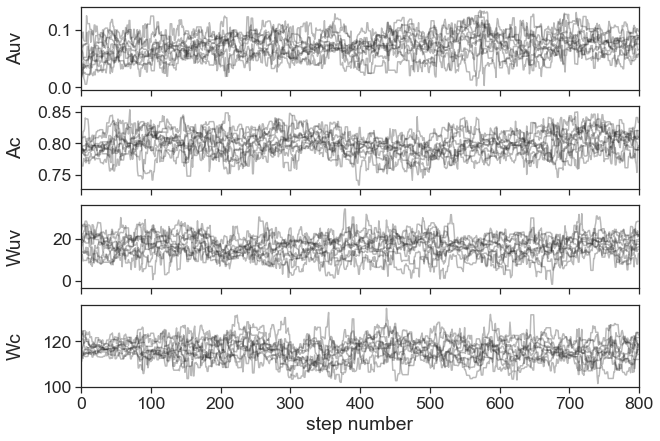

In [8]:





dis=200
labels = ["Auv","Ac","Wuv","Wc"]
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=dis)
logProb=sampler.get_log_prob(discard=dis)
maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
samples=np.array([s[maskWalkers] for s in samples])
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()




(8000, 4)


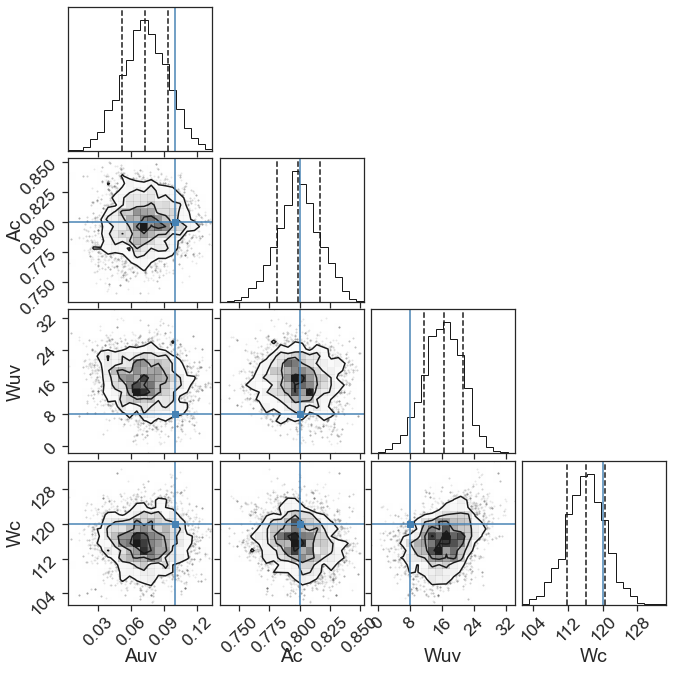

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:

ndim=len(labels)
samples = sampler.get_chain(discard=dis)
samples=np.array([s[maskWalkers] for s in samples])
samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
print(np.shape(samples))


fig = corner.corner(
    samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
)
plt.show()

results=[]
r16,r84=[],[]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    results.append(mcmc[1])
    r16.append(mcmc[0])
    r84.append(mcmc[2])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


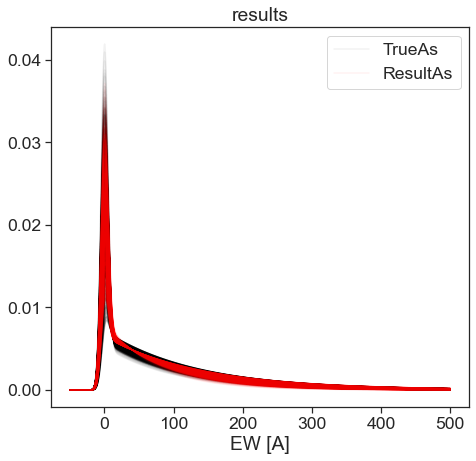

Median True values : 
A :  0.7865211427965271
W0 :  118.92169142372217
Median Result values : 
A :  0.7892025483059496
W0 :  113.9712159004778


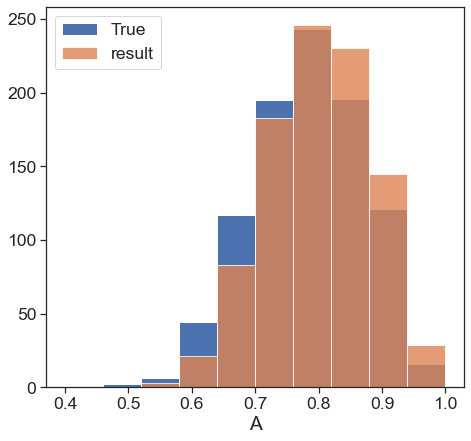

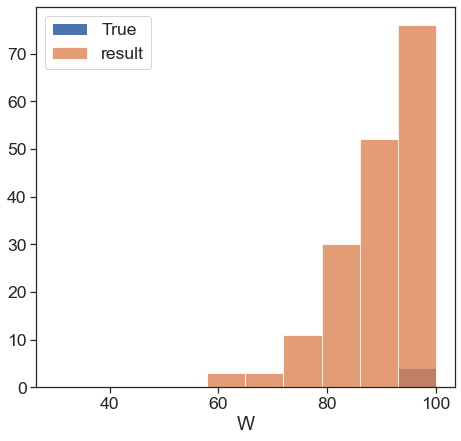

In [10]:
%load_ext autoreload
%autoreload

mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.05,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)




x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="red",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.plot(x,prob,color="red",alpha=0.05,label="ResultAs")
plt.legend()
plt.show()

resultAs=np.array(As)
resultWs=np.array(Ws)
mParamsA=r16[:2]
mParamsW=r16[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r16As=np.array(As)
r16Ws=np.array(Ws)
mParamsA=r84[:2]
mParamsW=r84[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r84As=np.array(As)
r84Ws=np.array(Ws)

print("Median True values : ")
print("A : ",np.median(TrueAs))
print("W0 : ",np.median(TrueWs))

print("Median Result values : ")
print("A : ",np.median(resultAs))
print("W0 : ",np.median(resultWs))

plt.hist(TrueAs,label="True",range=[0.4,1])
plt.hist(As,label="result",alpha=0.8,range=[0.4,1])
plt.xlabel("A")
plt.legend()
plt.show()

plt.hist(TrueWs,label="True",range=[30,100])
plt.hist(Ws,label="result",alpha=0.8,range=[30,100])
plt.xlabel("W")
plt.legend()
plt.show()



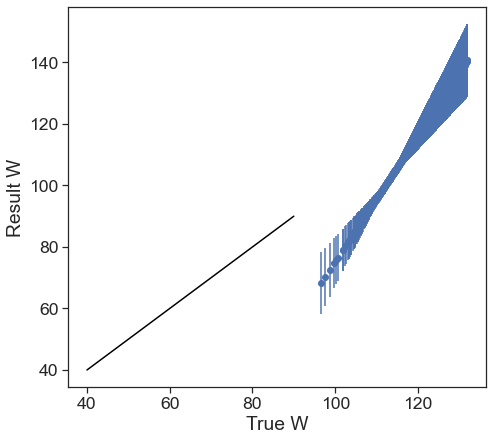

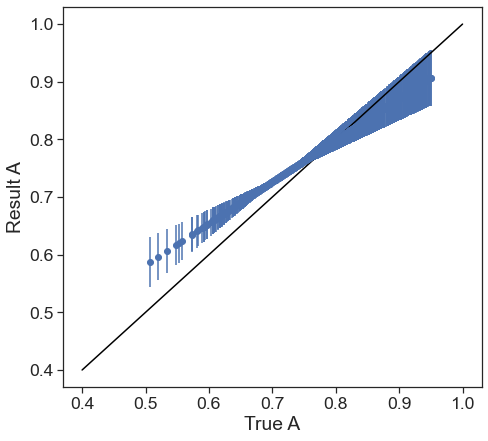

In [11]:
plt.errorbar(TrueWs,resultWs,yerr=resultWs-r16Ws,fmt="o")
plt.plot([40,90],[40,90],color="black")
plt.xlabel("True W")
plt.ylabel("Result W")
plt.show()

plt.errorbar(TrueAs,resultAs,yerr=resultAs-r16As,fmt="o")
plt.plot([0.4,1],[0.4,1],color="black")
plt.xlabel("True A")
plt.ylabel("Result A")
plt.show()

In [190]:
results

[0.09478523709390935, 0.4997505479897571, 5.056698362165138, 66.41316215539557]

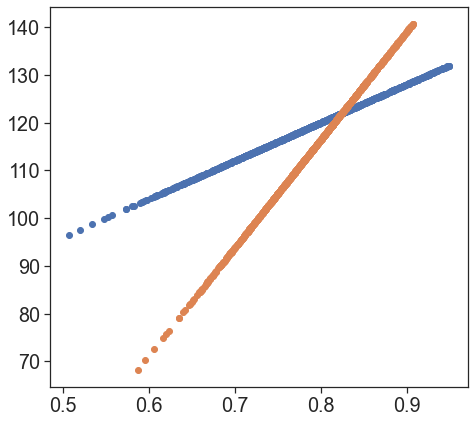

<ipython-input-25-044964aca403>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

<Figure size 540x504 with 0 Axes>

In [25]:
import imageio
from PIL import Image

results_transposed = np.transpose(results)
sns.set_theme(style="ticks",font_scale=1.8)
x,probSets1,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
plt.scatter(As,Ws)
x2,probSets2,Asr,Wsr=BInf.GenerateMockDataConvolved([np.median(results_transposed[0]),np.median(results_transposed[1])],[np.median(results_transposed[2]),np.median(results_transposed[3])])
plt.scatter(Asr,Wsr)
plt.show()
# Create a list to store the images
images = []

# Loop through the probSets1 and probSets2
delay = 1

# Loop through the probSets1 and probSets2
for p1, p2, muv,a,w,ar,wr in zip(probSets1, probSets2, BInf.Muv,As,Ws,Asr,Wsr):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p1,color="black",ls="--",lw=5,label="True")
    ax.plot(x, p2,lw=5,label="Result")
    ax.set_xlim(-10, 200)
    #ax.set_ylim(0, 0.013)
    # Add text for Muv in the top right corner
    ax.text(0.95, 0.75, f'Muv: {np.round(muv,1)}', transform=ax.transAxes, ha='right', va='top')
    #ax.text(0.95, 0.85, f'A: {a}', transform=ax.transAxes, ha='right', va='top')
    #ax.text(0.95, 0.75, f'W: {w}', transform=ax.transAxes, ha='right', va='top')
    #ax.text(0.95, 0.65, f'Ares: {ar}', transform=ax.transAxes, ha='right', va='top')
    #ax.text(0.95, 0.55, f'Wres: {wr}', transform=ax.transAxes, ha='right', va='top')
    ax.set_xlabel(r"EW$_{\mathrm{Ly\alpha}}$ [A]")
    ax.set_ylabel(r"P(EW$_{\mathrm{Ly\alpha}}$|Muv)")
    plt.tight_layout()
    plt.legend()
    # Save the figure as an image
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.clf()

# Save the images as a GIF with a slower frame rate
imageio.mimsave('plots_uplim.gif', images, duration=delay)

In [ ]:
steps=1000
nwalkers=10

#mockParamsA=[0.12,3.2]
#mockParamsW=[8,230]

inValuesA=[0.,0.9]
inValuesW=[0,50]

inValues=inValuesA+inValuesW

All_results=[]
for i in range(0,1):
    pos = inValues+ [0.01,0.2,1,30] * np.random.randn(nwalkers,len(inValues) )
    nwalkers, ndim = np.shape(pos)

    #mp_pool = multiproc.ProcessPool(nodes=8)
    #with mp_pool as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(EW_obs , dEW,)
    )
    sampler.run_mcmc(pos, steps, progress=True)


    dis=200
    labels = ["Auv","Ac","Wuv","Wc"]
    fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=dis)
    logProb=sampler.get_log_prob(discard=dis)
    maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
    samples=np.array([s[maskWalkers] for s in samples])
    for i in range(len(labels)):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.show()


    ndim=len(labels)
    samples = sampler.get_chain(discard=dis)
    samples=np.array([s[maskWalkers] for s in samples])
    samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
    print(np.shape(samples))


    fig = corner.corner(
        samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
    )
    plt.show()

    results=[]
    r16,r84=[],[]
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        r16.append(mcmc[0])
        r84.append(mcmc[2])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))

    All_results.append(results)

In [ ]:
%load_ext autoreload
%autoreload

mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x1,probSets1,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
for prob in probSets1[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.8,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)




x2,probSets2,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
for prob in probSets2[:]:
    plt.plot(x,prob,color="red",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.plot(x,prob,color="red",alpha=0.8,label="ResultAs")
plt.legend()
plt.show()




import imageio
from PIL import Image

# Create a list to store the images
images = []

# Loop through the probSets1 and probSets2
for p1, p2 in zip(probSets1, probSets2):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p1)
    ax.plot(x, p2)
    ax.set_xlim(-10, 200)
    
    # Save the figure as an image
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.close(fig)

# Save the images as a GIF
imageio.mimsave('plots.gif', images)

resultAs=np.array(As)
resultWs=np.array(Ws)
mParamsA=r16[:2]
mParamsW=r16[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r16As=np.array(As)
r16Ws=np.array(Ws)
mParamsA=r84[:2]
mParamsW=r84[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r84As=np.array(As)
r84Ws=np.array(Ws)

print("Median True values : ")
print("A : ",np.median(TrueAs))
print("W0 : ",np.median(TrueWs))

print("Median Result values : ")
print("A : ",np.median(resultAs))
print("W0 : ",np.median(resultWs))

plt.hist(TrueAs,label="True",range=[0.4,1])
plt.hist(As,label="result",alpha=0.8,range=[0.4,1])
plt.xlabel("A")
plt.legend()
plt.show()

plt.hist(TrueWs,label="True",range=[30,100])
plt.hist(Ws,label="result",alpha=0.8,range=[30,100])
plt.xlabel("W")
plt.legend()
plt.show()


In [ ]:
plt.errorbar(TrueWs,resultWs,yerr=resultWs-r16Ws,fmt="o")
plt.plot([40,90],[40,90],color="black")
plt.xlabel("True W")
plt.ylabel("Result W")
plt.show()

plt.errorbar(TrueAs,resultAs,yerr=resultAs-r16As,fmt="o")
plt.plot([0.4,1],[0.4,1],color="black")
plt.xlabel("True A")
plt.ylabel("Result A")
plt.show()

In [ ]:
for iiii in range(0,50):    
    steps=3000
    nwalkers=10

    #mockParamsA=[0.12,3.2]
    #mockParamsW=[8,230]

    inValuesA=[0.,0.9]
    inValuesW=[0,50]

    inValues=inValuesA+inValuesW


    pos = inValues+ [0.01,0.2,1,30] * np.random.randn(nwalkers,len(inValues) )
    nwalkers, ndim = np.shape(pos)

    #mp_pool = multiproc.ProcessPool(nodes=8)
    #with mp_pool as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(EW_obs , dEW,)
    )
    sampler.run_mcmc(pos, steps, progress=True)




    dis=1000
    labels = ["Auv","Ac","Wuv","Wc"]
    fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=dis)
    logProb=sampler.get_log_prob(discard=dis)
    maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
    samples=np.array([s[maskWalkers] for s in samples])
    for i in range(len(labels)):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.show()



    ndim=len(labels)
    samples = sampler.get_chain(discard=dis)
    samples=np.array([s[maskWalkers] for s in samples])
    np.save("results/samples"+str(iiii)+".npy",samples)
    samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
    print(np.shape(samples))


    fig = corner.corner(
        samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
    )
    plt.show()

    results=[]
    r16,r84=[],[]
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        r16.append(mcmc[0])
        r84.append(mcmc[2])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))


    np.save("results_uplim/results"+str(iiii)+".npy",results)

In [ ]:
import glob
resultados=glob.glob("results_uplim/results*.npy")

results=[]
for res in resultados:
    results.append(np.load(res))

resultWs=[]
resultAs=[]
for r in results:
    Amuv,Ac=r[0],r[1]
    Wmuv,Wc=r[2],r[3]                                                                                                      
    __,__,As,Ws=BInf.GenerateMockDataConvolved([Amuv,Ac],[Wmuv,Wc])
    resultWs.append(Ws)
    resultAs.append(As)

In [ ]:

for rW,rA in zip(resultWs,resultAs):
    plt.errorbar(TrueWs,rW,fmt="-",alpha=0.5,color="black")
    plt.plot([40,90],[40,90],color="black",ls="--")
    plt.xlabel("True W")
    plt.ylabel("Result W")
plt.show()
for rW,rA in zip(resultWs,resultAs):
    plt.errorbar(TrueAs,rA,alpha=0.5,fmt="-",color="black")
    plt.plot([0.4,1],[0.4,1],color="black",ls="--")
    plt.xlabel("True A")
    plt.ylabel("Result A")
plt.show()


In [ ]:
mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x,probSets,As,Ws=BInf.GenerateMockData(mockParamsA,mockParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.05,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)

In [ ]:
%load_ext autoreload
%autoreload

import imageio
from PIL import Image

results=[]
for res in resultados:
    results.append(np.load(res))

results_transposed = np.transpose(results)

x,probSets1,As,Ws=BInf.GenerateMockData(mockParamsA,mockParamsW)
x2,probSets2,As,Ws=BInf.GenerateMockData([np.median(results_transposed[0]),np.median(results_transposed[1])],[np.median(results_transposed[2]),np.median(results_transposed[3])])

# Create a list to store the images
images = []

# Set the delay between frames (in seconds)
delay = 0.5

# Loop through the probSets1 and probSets2
for p1, p2, muv in zip(probSets1, probSets2, BInf.Muv):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p1,color="black",ls="--")
    ax.plot(x, p2)
    ax.set_xlim(-10, 200)
    #ax.set_ylim(0, 0.013)
    # Add text for Muv in the top right corner
    ax.text(0.95, 0.95, f'Muv: {muv}', transform=ax.transAxes, ha='right', va='top')
    
    # Save the figure as an image
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.show()

# Save the images as a GIF with a slower frame rate
imageio.mimsave('plots_uplim.gif', images, duration=delay)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.010591825077094415


ValueError: x and y must have same first dimension, but have shapes (2,) and (5501,)

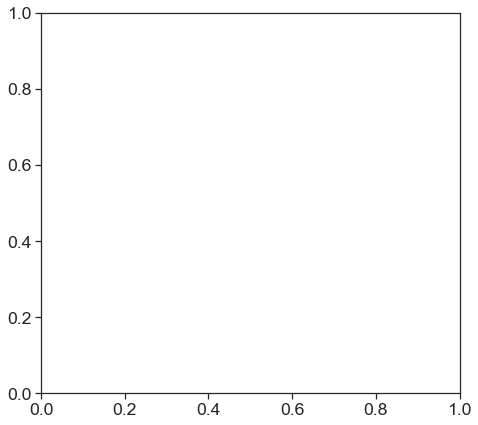

In [117]:
%load_ext autoreload
%autoreload

def OGLikelihood(ew,A,Wo):
    return ((A/Wo)*np.exp(-ew/Wo)*np.heaviside(ew,0.0) + (1-A)*DeltaFunc(ew) )

x2,probSets2,As,Ws=BInf.GenerateMockData([0.106,2.91],[10.29,280.22])
for p1, p2, muv in zip(probSets1[:10], probSets2[:10], BInf.Muv[:10]):
    #print(10.28*muv+280.22)
    #print(0.106*muv+2.91)
    print((0.106*muv+2.91)/(10.28*muv+280.22)*np.exp(-0.1/(10.28*muv+280.22)))
    fig, ax = plt.subplots()
    
    ax.plot(x, p1,color="black",ls="--")
    ax.plot(x, p2)
    ax.plot(x2, OGLikelihood(x2,0.73,63.55))


    ax.set_xlim(-10, 200)
    ax.set_ylim(0, 0.013)
    ax.axhline(0.0105, color='red')
    ax.text(0.95, 0.95, f'Muv: {muv}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.75, f'A: {0.106*muv+2.91}', transform=ax.transAxes, ha='right', va='top')
plt.show()


In [130]:
0.106/10.28

0.010311284046692607

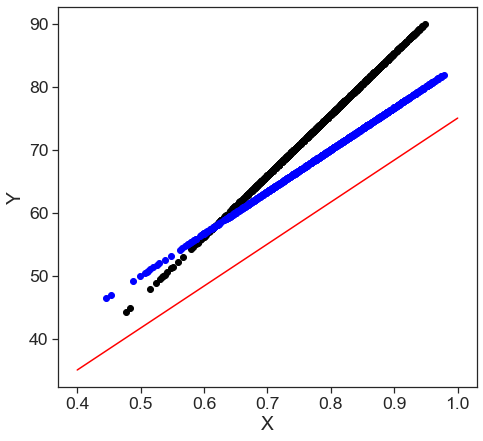

In [128]:

for p1, p2, muv in zip(probSets1[:], probSets2[:], BInf.Muv[:]):
    #print(10.28*muv+280.22)
    #print(0.106*muv+2.91)
    plt.scatter((0.106*muv+2.91),(10.28*muv+280.22),color="black")



plt.scatter(TrueAs,TrueWs,color="blue")

x = [0.4, 1]
y = [35, 35 + (8/0.12 * (1 - 0.4))]

plt.plot(x, y, color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


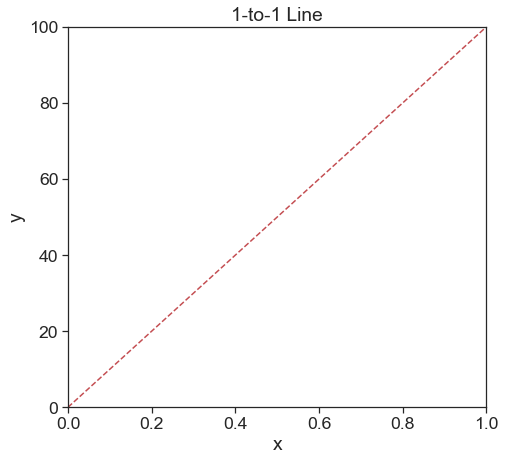

In [116]:
import matplotlib.pyplot as plt

x = [0, 1]
y = [0, 100]

plt.plot(x, y, 'r--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('1-to-1 Line')
plt.xlim(0, 1)
plt.ylim(0, 100)
plt.show()
